In [13]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### PERFECT EXPONENTIAL GENERATOR (FOR GEOMETRIC ESTIMATOR)

In [14]:
def generate_exponential_perfect(mean, size):
    """
    Generates random numbers following an exponential distribution

    Args:
        mean (float): The mean of the distribution.
        size (int): The number of random numbers to generate.

    Returns:
        An array of random numbers following an exponential distribution
        with the given mean.
    """
    return np.random.exponential(scale=mean, size=size)

<AxesSubplot:ylabel='Count'>

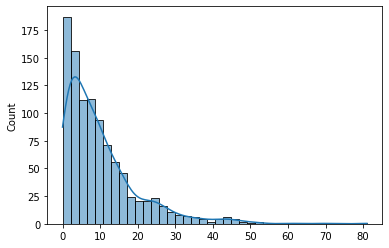

In [15]:
mean = 10
size= 1000
Y = generate_exponential_perfect(mean, size)
sns.histplot(Y, kde = True)

##### geometric estimator

In [16]:
def geom_estimator(T):
    """
    Function to calculate the geometric clv estimator
    
    Parameters:
    T (list or array): list or array of numerical values
    
    Returns:
    float: the geometric clv estimator of the values in T
    """
    return np.sum(T)/len(T)

In [17]:
clv_geom = geom_estimator(Y)
epsilon = 0.001
n = 1000
while (np.abs(clv_geom-mean)>epsilon):
    n += 1
    clv_geom = geom_estimator(generate_exponential_perfect(mean, n))



In [18]:
print("CONVERGENCE WITH DIFFERENCE OF ε = %.4f :\n \t size of dataset =%d \n \t CLV real = %f \n \t CLV thoery = %d" % (epsilon, n ,clv_geom,mean))

CONVERGENCE WITH DIFFERENCE OF ε = 0.0010 :
 	 size of dataset =1941 
 	 CLV real = 9.999901 
 	 CLV thoery = 10


##### EXPONENTIAL GENERATOR (FOR EXPONENTIAL ESTIMATOR - with non available data)

In [19]:
def generate_exponential(mean, size , obs_duration):
    T = np.random.exponential(scale=mean, size=size)
    ancient = obs_duration * np.random.rand(size)
    Y = T*(T<=ancient) +  ancient*(T>ancient)
    return Y , ancient

<AxesSubplot:ylabel='Count'>

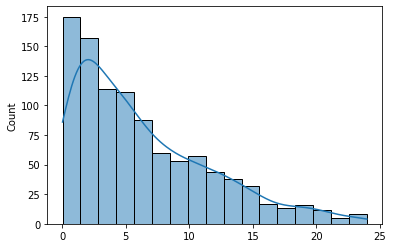

In [20]:
mean = 10
size= 1000
DureeObs = 12*2
Y, ancient = generate_exponential(mean, size, DureeObs)
sns.histplot(Y, kde = True)

In [21]:
len(np.where(Y==ancient)[0])

399

In [22]:
def exp_estimator(Y , ancient):
    A = np.where(Y!=ancient)[0]
    return np.sum(Y) /len(A)

In [23]:
clv_exp = exp_estimator(Y,ancient)
epsilon = 0.001
n = 1000
while (np.abs(clv_exp-mean)>epsilon):
    n += 1
    Y_new, ancient_new = generate_exponential(mean, n,DureeObs )
    clv_exp = exp_estimator(Y_new, ancient_new)


In [24]:
print("CONVERGENCE WITH DIFFERENCE OF ε = %.4f :\n \t size of dataset =%d \n \t CLV real = %f \n \t CLV thoery = %d" % (epsilon, n ,clv_exp,mean))

CONVERGENCE WITH DIFFERENCE OF ε = 0.0010 :
 	 size of dataset =1006 
 	 CLV real = 9.999031 
 	 CLV thoery = 10


##### PARETO 

In [15]:
# GENERATOR WITH TWO PARETO DISTRIBUTION

# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
shape1 = 0.1  # Small shape: close to exponential distribution

moyenne2 = 9  # Mean in the second group
shape2 = 0.4  # Larger shape: heavy-tailed distribution

ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = ratio_classe*moyenne1+(1-ratio_classe)*moyenne2

# Data generation
location1 = 0
scale = moyenne1*(1-shape1)-location1
T1 = np.random.gamma(shape1, scale, n)

location2 = 0
scale = moyenne2*(1-shape2)-location2
T2 = np.random.gamma(shape2, scale, n)

ber = np.random.rand(n) > ratio_classe

T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n)
Y = T*(T<Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)


# The data is now (Y, Duree_depuis_souscription)

In [21]:
# GENERATOR WITH ONLY ONE PARETO DISTRIBUTION

# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
shape1 = 0.1  # Small shape: close to exponential distribution

#moyenne2 = 9  # Mean in the second group
#shape2 = 0.4  # Larger shape: heavy-tailed distribution

#ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = moyenne1 #+(1-ratio_classe)*moyenne2

# Data generation
location1 = 0   # Que fait location et que fait shape
scale = moyenne1*(1-shape1)-location1
T1 = np.random.gamma(shape1, scale, n)


# location2 = 0
# scale = moyenne2*(1-shape2)-location2
# T2 = np.random.gamma(shape2, scale, n)

# ber = np.random.rand(n) > ratio_classe  

# T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n) # Q
Y = T*(T<=Duree_depuis_souscription) +  Duree_depuis_souscription*(T>Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)

# The data is now (Y, Duree_depuis_souscription)

In [22]:
df = pd.DataFrame({'Y': Y, 'DUREE_SOUSCRIPTION':Duree_depuis_souscription}, columns=['Y', 'DUREE_SOUSCRIPTION'])

In [6]:
df.describe()

,Y,DUREE_SOUSCRIPTION
count,1.000000e+03,1000.000000
mean,1.615666e+00,23.688893
std,2.747478e+00,13.790997
min,9.522746e-30,0.000393
25%,1.729085e-02,11.809748
50%,3.602399e-01,23.197198
75%,2.009835e+00,35.492942
max,1.943005e+01,47.993324


In [7]:
# null values
df.isnull().sum()

Y                     0
DUREE_SOUSCRIPTION    0
dtype: int64

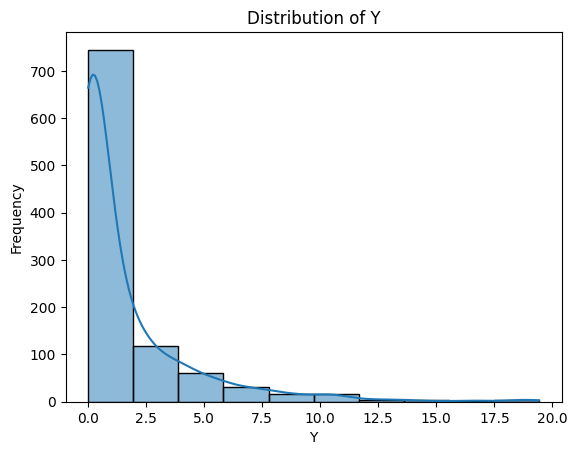

In [8]:
sns.histplot(Y, bins=10, kde = True)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Distribution of Y')
plt.show()

#### Parametric estimator

In [9]:
# Define the estimator function
#
def clv_geom(Y, DS):
    np.where(~np.isnan(Y))[0]  
    N = np.where(np.isnan(Y))[0]
    return (np.sum(Y[A]) + np.sum(DS[N]))/len(A)

In [10]:
# Define the estimator function
def clv_pareto(Y, DS):
    D = len(Y[Y<Duree_depuis_souscription])
    denom = 1- (np.sum(np.log(Y))/D)
    return 1 / denom

In [11]:
# Define the estimator function
def CLV_pareto_IC(Y, DS):
    D = len(Y[Y<Duree_depuis_souscription])
    denom = 1- (np.sum(np.log(Y))/D)
    return 1 / denom

In [12]:
print("CLV HAT :",clv_pareto(Y,Duree_depuis_souscription))
print("CLV :", CLV)

CLV HAT : 0.2358562487018346
CLV : 4


In [13]:
print("CLV HAT :",clv_geom(Y,Duree_depuis_souscription))
print("CLV :", CLV)

NameError: ignored

##### Confidence interval

In [ ]:
# Perform bootstrap sampling to estimate confidence interval
B = 200  # Number of bootstrap samples
bootstrap_samples = np.random.choice(n, size=(B, n), replace=True)
bootstrap_estimators = np.zeros(B)
for b in range(B):
    Y_b = Y[bootstrap_samples[b]]
    DS_b = Duree_depuis_souscription[bootstrap_samples[b]]
    bootstrap_estimators[b] = clv_hat(Y_b, DS_b)

# Compute confidence interval
alpha = 0.05  # Significance level
lower = np.percentile(bootstrap_estimators, 100*(alpha/2))
upper = np.percentile(bootstrap_estimators, 100*(1-alpha/2))

print("CLV hat: ", clv_hat(Y, Duree_depuis_souscription))
print("95% confidence interval: [", lower, ",", upper, "]")

In [ ]:
print("VAR(CLV hat): ", bootstrap_estimators.std()**2)

In [ ]:
import seaborn as sns

# Plot the bar chart
sns.histplot(bootstrap_estimators, bins=30, kde=True)

# Show the plot
plt.show()



#### Geometric

In [ ]:
# Parameters
n = 1000
DureeObs = 12*4

moyenne1 = 4  # Mean in the first group
p1 = 0.2  # Probability of success in each trial, for a geometric distribution

moyenne2 = 9  # Mean in the second group
p2 = 0.6  # Probability of success in each trial, for a geometric distribution

ratio_classe = 0.3  # Proportion of clients in the first group in the dataset

# Expectation across both groups
CLV = ratio_classe*moyenne1+(1-ratio_classe)*moyenne2

# Data generation
T1 = np.random.geometric(p1, n)/p1 - 1  # Subtract 1 to shift distribution
T1 = T1 * moyenne1/np.mean(T1)  # Rescale to match mean

T2 = np.random.geometric(p2, n)/p2 - 1  # Subtract 1 to shift distribution
T2 = T2 * moyenne2/np.mean(T2)  # Rescale to match mean

ber = np.random.rand(n) > ratio_classe

T = (1-ber)*T1 + ber*T2

Duree_depuis_souscription = DureeObs * np.random.rand(n)
Y = T*(T<Duree_depuis_souscription)
#Y = np.where(T<Duree_depuis_souscription, T, np.nan)

# The data is now (Y, Duree_depuis_souscription)


In [ ]:
df2 = pd.DataFrame({'Y': Y, 'DUREE_SOUSCRIPTION':Duree_depuis_souscription}, columns=['Y', 'DUREE_SOUSCRIPTION'])

In [ ]:
df2.describe()

In [ ]:
print("CLV HAT :",clv_hat(Y,Duree_depuis_souscription))
print("CLV :", CLV)

In [ ]:
# Perform bootstrap sampling to estimate confidence interval
B = 200  # Number of bootstrap samples
bootstrap_samples = np.random.choice(n, size=(B, n), replace=True)
bootstrap_estimators = np.zeros(B)
for b in range(B):
    Y_b = Y[bootstrap_samples[b]]
    DS_b = Duree_depuis_souscription[bootstrap_samples[b]]
    bootstrap_estimators[b] = clv_hat(Y_b, DS_b)

# Compute confidence interval
alpha = 0.05  # Significance level
lower = np.percentile(bootstrap_estimators, 100*(alpha/2))
upper = np.percentile(bootstrap_estimators, 100*(1-alpha/2))

print("CLV hat: ", clv_hat(Y, Duree_depuis_souscription))
print("95% confidence interval: [", lower, ",", upper, "]")

In [ ]:
# Plot the bar chart
sns.histplot(bootstrap_estimators, bins=30, kde=True)

# Show the plot
plt.show()


### Quick trial of scikit learn survival analysis package

[Survival analysis](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#What-is-Survival-Analysis?)

In [ ]:
!pip install scikit-survival  

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sksurv.datasets import load_aids

In [ ]:
# read the dataset
# ex other type of data : bank information source kaggle : https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?resource=download

"""
AIDS Clinical Trial dataset
The dataset has 1,151 samples and 11 features. The dataset has 2 endpoints:
.AIDS defining event, which occurred for 96 patients (8.3%)
.Death, which occurred for 26 patients (2.3%)
"""

# data_x : The measurements for each patient.
data_x, data_y = load_aids()

In [ ]:
data_x.head(3)

e.tdm: boolean indicating whether the endpoint has been reached or the event time is right censored.

t.tdm: time to distant metastasis (days)

In [ ]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

In [ ]:
%matplotlib inline
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["censor"], data_y["time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [ ]:
survival_times = np.array([5, 3, 2, 4, 7, 6, 5, 1, 8, 4, 3, 5, 6])
event_indicators = np.array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])
event_indicators_bool = [x==1 for x in event_indicators]

In [ ]:
t , s = kaplan_meier_estimator(event_indicators_bool, survival_times )
plt.plot(t, s)
plt.ylabel("probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Survival function properties:
$$\hat S(t) = \prod_{t_i \leq t} \frac{n_i - d_i}{n_i} = \prod_{t_i \leq t} 1 - \frac{d_i}{n_i} =\prod_{t_i \leq t} 1 - \frac{\text{number of events that happened at time }t_i }{\text{number of individuals known to have survived up to time }t_i } = \prod_{t_i \leq t} p_{t_i} $$

Another form:
$$\hat S(t) = \hat S(t-1)p_t$$


In [ ]:
def kaplan_meier_estm(event_indicators , survival_times ):
    """
    Fits the Kaplan-Meier survival curve to the input event indicators and survival times.

    Parameters:
    survival_times (np array): time from study inclusion to event (death, relapse, etc.)
    event_indicators (binary np array): the event of interest that occurs during the follow-up time (e.g., mortality, relapse, etc.)

    Returns:
    s (np array): estimated survival probabilities at each time point
    t (np array): unique times at which the estimated survival probabilities change.
    """

    # length of dataset
    n = len(survival_times)

    # compute unique survival times
    t = np.unique(survival_times)
    m = len(t)

    # array that store the survival probabilities
    s = np.ones(m)

    # array that store the number of events
    d = np.zeros(m)

    for i in range(m):
        # Count the number of events that occur (event indicator = 1) at time i
        d[i] = np.sum((survival_times == t[i]) & event_indicators)

        # compute the survival probability at time i
        n_i = n - sum(d[:i]) # - d
        s[i] = s[max(0, i-1)] * (1 - d[i] / n_i)
    return t, s


In [ ]:
# Example usage

t_new, s_new = kaplan_meier_estm(event_indicators , survival_times)
print("Difference with KME of sklearn t:",t-t_new)
print("Difference with KME of sklearn s:",s-s_new)
plt.plot(t_new, s_new)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Kaplan-Meier Survival Curve")
plt.show()

In [ ]:
#problem : difference of 0.2 on the probabilities ... choice of the formula? 
#next: fonction fit - selon un clustering ? predict - métriques? ??

### Dataset

Since there's not access to the real data, the first step to do is to find/construct a dataset where the CLV can measurable/predictable. One can need to have some features such as: 
* Personal information : occupation, salary, gender, age, marital status, Geolocalisation (Country/town ...etc)
* Date of entry to company/study
* Date of leaving (can be empty if the element didn't quit yet)
* Information related to the person as a client : number & types of products , communication email/call ...